# Sentiment Analysis on StockTwits

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

import json, re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from scipy import sparse as sp_sparse

from sklearn.model_selection import train_test_split

data_dir = '../nlp_datasets/13_twitter_sentiment/'

In [2]:
def load_data():
    with open(data_dir+'train_twits.json', 'r') as f:
        twits = json.load(f)
    df = pd.DataFrame(twits['data'])
    return df
    
data = load_data()

In [3]:
df_top = data.loc[:100000]

In [4]:
df= df_top.copy()
df['sentiment'] = df['sentiment'].apply(lambda x:x+2)
print ('unique sentiments:', df.sentiment.unique() )

unique sentiments: [4 3 2 0 1]


## Class (Im)balance

In [5]:
def balance_class(df, col='sentiment'):
    dfb=df.copy()
    counts = dict(dfb[col].value_counts())
    print ("initial counts for each classes:", counts)
    min_count = min(counts.values())
    min_indx  = [k for k in counts.keys() if counts[k]==min_count][0]
    print ("min_index:", min_indx, "min count:", min_count)

    for s in dfb[col].unique():
        delete_after = dfb[dfb[col]==min_indx].shape[0] 
        indices_to_delete = dfb[dfb[col]==s].index.values[delete_after:]
        dfb = dfb.drop(index=indices_to_delete, axis=0)
    return dfb

df=balance_class(df, col='sentiment')


initial counts for each classes: {2: 47646, 3: 20202, 4: 14097, 1: 10494, 0: 7562}
min_index: 0 min count: 7562


## Data Preprocessing


In [6]:
import re

STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    text = text.lower() # lowercase text
    text = re.sub(r'https?://\S+', ' ', text)# Replace URLs with a space
    text = re.sub(r'\$\S+', ' ', text)       # Replace ticker symbols with a space
    text = re.sub(r'\@\S+', ' ', text)       # Replace StockTwits usernames with a space.
    text = re.sub(r'[^a-zA-Z]', ' ', text)   # Replace everything not a letter with a space        
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwors from text
    return text

In [7]:
df['message_processed'] = df['message_body'].apply(text_prepare)
df.head(2)

,message_body,sentiment,timestamp,message_processed
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,great buy ill wait
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z,


In [8]:
def split_data(data):
    df_train_, df_test = train_test_split(data, test_size=0.2)
    df_train, df_val = train_test_split(data, test_size=0.25)
    return df_train, df_val, df_test

df_train, df_val, df_test = split_data(df)

In [9]:
from collections import Counter

ALL_WORDS = [word for message in df_train['message_processed'] for word in message.split()]
words_counts = Counter(ALL_WORDS)

words_counts_sorted = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)

DICT_SIZE = 1000
VOCAB = words_counts.most_common(DICT_SIZE)  # already sorted
WORDS_TO_INDEX = {item[0]:ii for ii, item in enumerate(VOCAB) }
INDEX_TO_WORDS = {ii:word for word, ii in WORDS_TO_INDEX.items()}

### Convert labels to categorical 

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

onehot_encoder=OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(np.array(df_train['sentiment'].values).reshape(-1,1))
y_val = onehot_encoder.transform(np.array(df_val['sentiment'].values).reshape(-1,1))
y_test = onehot_encoder.transform(np.array(df_test['sentiment'].values).reshape(-1,1))


## Bag of Words (BoW) method

In [11]:
def my_bag_of_words(text, words_to_index, dict_size):
    result_vec = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vec[words_to_index[word]] +=1
    return result_vec
        
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in df_train['message_processed']])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in df_val['message_processed']])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in df_test['message_processed']])
print ("Bow Method")
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

Bow Method
X_train shape  (28357, 1000)
X_val shape  (9453, 1000)
X_test shape  (7562, 1000)


## TF-IDF method

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_val, X_test):
    # max_df and min_df is to filter out too frequent and too rare words
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                 max_df=0.9, min_df=5,
                                 token_pattern='(\S+)' )

    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return (X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer )


In [13]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer = tfidf_features(df_train['message_processed'],
                                           df_val['message_processed'],
                                           df_test['message_processed'])

In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

def train_classifier(X_train, y_train):
    model = OneVsRestClassifier(LogisticRegression(penalty='l2', C=1.0, max_iter=500))
    model.fit(X_train, y_train)
    return model

clf_bow = train_classifier(X_train_mybag, y_train)
clf_tfidf = train_classifier(X_train_tfidf, y_train)


In [15]:
y_val_predicted_labels_mybag = clf_bow.predict(X_val_mybag)
y_val_predicted_scores_mybag = clf_bow.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = clf_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = clf_tfidf.decision_function(X_val_tfidf)

In [16]:
y_val_labels_mybag = np.argmax(y_val_predicted_scores_mybag, axis=1)
y_val_labels_tfidf = np.argmax(y_val_predicted_scores_tfidf, axis=1)

In [17]:
# Accuracy measures
y_val_actual = df_val['sentiment']

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score   #  extra arguement 'average' is required for multiclass/multilabel targets.
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import recall_score

def print_evaluation_scores(y_actual, y_pred):
    print ( f"Accuracy score: %1.2f " % (100*accuracy_score(y_actual, y_pred)) )
    print ( f"f1 score: %1.2f" % (100*f1_score(y_actual, y_pred, average='macro')) )
    
print ("Bag of Words method:")
print_evaluation_scores(y_val_actual, y_val_labels_mybag)

print ("\nTFIDF method:")
print_evaluation_scores(y_val_actual, y_val_labels_tfidf)

Bag of Words method:
Accuracy score: 58.73 
f1 score: 58.33

TFIDF method:
Accuracy score: 61.78 
f1 score: 61.46


7


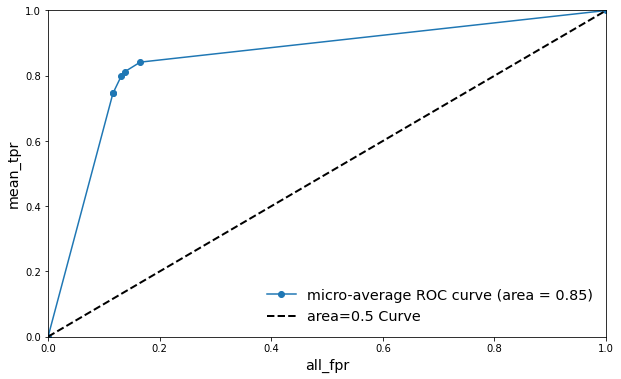

In [19]:
from sklearn.metrics import roc_curve, auc 
from numpy import interp
from itertools import cycle

def plot_roc_auc():
    

    fpr = {}
    tpr = {}
    roc_auc = {}
    n_classes = 5
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve( y_val_predicted_labels_tfidf[:, i], y_val[:,i] ) 
        roc_auc[i] = auc(fpr[i], tpr[i] )

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_predicted_labels_tfidf.ravel(), y_val.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr  = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes 

    print ( len(all_fpr) )

    plt.figure(figsize=(10, 6))
    plt.plot(all_fpr, mean_tpr, '-o',
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
    plt.plot([0,1], [0,1], ls='--', lw=2., color='k', label="area=0.5 Curve")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('all_fpr', fontsize="x-large")
    plt.ylabel('mean_tpr', fontsize="x-large")
    plt.legend(fontsize='x-large', frameon=False);
    
plot_roc_auc()

In [20]:
# saving model
import pickle

with open('model_LR_bow.pkl', 'wb') as fw:
    pickle.dump(clf_bow, fw)
    
with open('model_LR_tfidf.pkl', 'wb') as fw:
    pickle.dump(clf_tfidf, fw)
    
with open('vectorizer_tfidf.pkl', 'wb') as fw:
    pickle.dump(tfidf_vectorizer, fw)

## Predictions

In [21]:
def Prediction(txt, bow=True):
    
    model_tfidf = pickle.load(open('model_LR_tfidf.pkl', 'rb'))
    model_bow = pickle.load(open('model_LR_bow.pkl', 'rb'))
    tfidf_vec = pickle.load(open('vectorizer_tfidf.pkl', 'rb'))
    
    sentiment_dict = {0:'very bad', 1:'bad', 2:'neutral', 
                     3:'good', 4:'very good'}
    
    processed_text = text_prepare(txt)
    #print (processed_text)
    if bow:
        x = my_bag_of_words(processed_text, WORDS_TO_INDEX, DICT_SIZE).reshape(1,-1)
        pred = model_bow.predict(x)
        
    else:
        x = tfidf_vectorizer.transform([processed_text])
        VOCAB=tfidf_vec.vocabulary_
        pred = model_tfidf.predict(x)
        print (pred)

    print (f"The following tweet {txt} \n\nhas a {sentiment_dict[np.argmax(pred)]} sentiment")
    
txt = "$AMD I heard there’s a guy who knows someone \
        who thinks somebody knows something - on StockTwits."

Prediction(txt, bow=True)

The following tweet $AMD I heard there’s a guy who knows someone         who thinks somebody knows something - on StockTwits. 

has a neutral sentiment
